In [7]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip -q install torch_geometric scikit-learn

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv

BASE = Path("/content/drive/MyDrive/biolip_gnn")
LABELED_DIR = BASE / "graphs_labeled_v3"
OUT_DIR = BASE / "out"
OUT_DIR.mkdir(exist_ok=True)

npz_files = sorted(LABELED_DIR.glob("*.npz"))
print("Labeled graphs:", len(npz_files))

def load_npz(path: Path) -> dict:
    z = np.load(path, allow_pickle=True)
    return {k: z[k] for k in z.files}

raw_graphs = [load_npz(p) for p in npz_files]
print("Loaded:", len(raw_graphs), "graphs")
print("Example keys:", raw_graphs[0].keys())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Labeled graphs: 50
Loaded: 50 graphs
Example keys: dict_keys(['pdb_id', 'chain', 'coords', 'x_idx', 'edge_index', 'edge_dist', 'resseq', 'n_nodes', 'n_edges', 'y', 'label_mode'])


In [8]:
# build PyG Data objects, with optimal degree feature
from torch_geometric.utils import degree

def to_pyg(graph_dict: dict, add_degree: bool=False) -> Data:
  x_idx = torch.tensor(graph_dict["x_idx"], dtype = torch.long)
  edge_index = torch.tensor(graph_dict["edge_index"], dtype = torch.long)
  y = torch.tensor(graph_dict["y"], dtype=torch.long)

  x = x_idx.view(-1, 1)

  if add_degree:
    deg = degree(edge_index[0], num_nodes=x.size(0)).view(-1, 1).float()
    # normalize degree so scales dont explode
    deg = (deg - deg.mean()) / (deg.std() + 1e-9)
    x = torch.cat([x, deg], dim = 1)

  edge_attr = None
  if "edge_dist" in graph_dict:
    edge_attr = torch.tensor(graph_dict["edge_dist"], dtype = torch.float).view(-1, 1)
  d = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
  d.pdb_id = str(graph_dict.get("pdb_id", ""))
  d.chain = str(graph_dict.get("chain", ""))
  return d

dataset_base = [to_pyg(g, add_degree = False) for g in raw_graphs]
dataset_deg = [to_pyg(g, add_degree = True) for g in raw_graphs]

print("Example base x shape:", dataset_base[0].x.shape)
print("Example deg  x shape:", dataset_deg[0].x.shape)

Example base x shape: torch.Size([387, 1])
Example deg  x shape: torch.Size([387, 2])


In [19]:
# define model variants

class SAGE_NodeClassifier(nn.Module):
    def __init__(self, num_aa=21, emb_dim=32, hidden=64, use_degree=False):
        super().__init__()
        self.use_degree = use_degree
        self.emb = nn.Embedding(num_aa, emb_dim)

        in_dim = emb_dim + (1 if use_degree else 0)

        self.conv1 = SAGEConv(in_dim, hidden)
        self.conv2 = SAGEConv(hidden, hidden)
        self.lin1  = nn.Linear(hidden, hidden)
        self.lin2  = nn.Linear(hidden, 1)

    def forward(self, data):
        # data.x[:,0] is AA index; data.x[:,1] is degree if present
        aa_idx = data.x[:, 0].long()
        h = self.emb(aa_idx)

        if self.use_degree:
            deg = data.x[:, 1].view(-1,1).float()
            h = torch.cat([h, deg], dim=1)

        h = F.relu(self.conv1(h, data.edge_index))
        h = F.relu(self.conv2(h, data.edge_index))
        h = F.relu(self.lin1(h))
        logits = self.lin2(h).squeeze(-1)
        return logits



In [22]:
# metrics: PR curve, AUPRC, best threshold on validation

from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

@torch.no_grad()
def collect_probs_and_labels(model, loader, device):
    model.eval()
    all_probs, all_y = [], []
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        y = batch.y.detach().cpu().numpy()
        all_probs.append(probs)
        all_y.append(y)
    return np.concatenate(all_probs), np.concatenate(all_y)

def pr_metrics(probs, y_true):
    ap = average_precision_score(y_true, probs)  # AUPRC
    prec, rec, thr = precision_recall_curve(y_true, probs)
    # precision_recall_curve returns thresholds of length (len(prec)-1)
    f1 = (2*prec[:-1]*rec[:-1]) / (prec[:-1]+rec[:-1] + 1e-9)
    best_i = int(np.argmax(f1))
    best_thr = float(thr[best_i])
    best = {
        "auprc": float(ap),
        "best_thr_f1": best_thr,
        "best_f1": float(f1[best_i]),
        "best_precision": float(prec[best_i]),
        "best_recall": float(rec[best_i]),
    }
    return best, (prec, rec, thr, f1)



In [23]:
# one split experiment: train baseline + train + degree, tune, threshold, evaluate on test
import random

def split_dataset(ds, seed=42):
  ds = ds.copy()
  random.Random(seed).shuffle(ds)
  n = len(ds)
  n_train = int(0.7*n)
  n_val = int(0.15*n)
  return ds[:n_train], ds[n_train:n_train+n_val], ds[n_train+n_val:]

def pos_weight_from_train(train_set):
  pos = sum(int(d.y.sum()) for d in train_set)
  tot = sum(int(d.y.numel()) for d in train_set)
  neg = tot - pos
  return torch.tensor([neg / max(pos, 1)], dtype = torch.float), pos, tot

def train_model(train_set, val_set, use_degree=False, seed=42, epochs=15):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = SAGE_NodeClassifier(use_degree = use_degree).to(device)

  train_loader = DataLoader(train_set, batch_size=4, shuffle = True)
  val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

  pw, pos, tot = pos_weight_from_train(train_set)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pw.to(device))
  opt = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-4)

  def run_epoch(loader, train=False):
    model.train() if train else model.eval()
    total_loss = 0.0
    for batch in loader:
      batch = batch.to(device)
      with torch.set_grad_enabled(train):
       logits = model(batch)
       y = batch.y.float()
       loss = criterion(logits, y)
       if train:
        opt.zero_grad()
        loss.backward()
        opt.step()
      total_loss += float(loss.item())
    return total_loss / max(len(loader), 1)

  for ep in range(1, epochs+1):
    tr_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)

  # collect validation probs to tunr threshold
  val_probs, val_y = collect_probs_and_labels(model, val_loader, device)
  val_best, _ = pr_metrics(val_probs, val_y)

  return model, val_best

def eval_on_test(model, test_set, thr, use_degree=False):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  test_loader = DataLoader(test_set, batch_size=4, shuffle=False)
  probs, y_true = collect_probs_and_labels(model, test_loader, device)

  y_pred = (probs >= thr).astype(int)

  #metrics
  tp = int(((y_pred == 1) & (y_true==1)).sum())
  fp = int(((y_pred == 1) & (y_true==0)).sum())
  fn = int(((y_pred == 0) & (y_true==1)).sum())

  precision = tp / (tp+fp+1e-9)
  recall = tp / (tp+fn+1e-9)
  f1 = (2*precision*recall) / (precision+recall+1e-9)
  ap = float(average_precision_score(y_true, probs))
  cm = confusion_matrix(y_true, y_pred)

  return {
      "test_auprc": ap,
      "test_precision": precision,
      "test_recall": recall,
      "test_f1": f1,
      "thr_used": float(thr),
      "confusion_matrix": cm
  }

# run one split
train_b, val_b, test_b = split_dataset(dataset_base, seed=42)
train_d, val_d, test_d = split_dataset(dataset_deg, seed=42)

model_base, val_best_base = train_model(train_b, val_b, use_degree=False, seed=42)
model_deg, val_best_deg = train_model(train_d, val_d, use_degree=True, seed=42)

test_base = eval_on_test(model_base, test_b, val_best_base["best_thr_f1"])
test_deg = eval_on_test(model_deg, test_d, val_best_deg["best_thr_f1"])

val_best_base, test_base, val_best_deg, test_deg


({'auprc': 0.12811726278012836,
  'best_thr_f1': 0.6856231689453125,
  'best_f1': 0.19011406794112967,
  'best_precision': 0.19230769230769232,
  'best_recall': 0.18796992481203006},
 {'test_auprc': 0.1381748508187963,
  'test_precision': 0.16883116883007254,
  'test_recall': 0.23214285714078442,
  'test_f1': 0.1954887213155068,
  'thr_used': 0.6856231689453125,
  'confusion_matrix': array([[1620,  128],
         [  86,   26]])},
 {'auprc': 0.14880952086587954,
  'best_thr_f1': 0.40101122856140137,
  'best_f1': 0.21287779208999846,
  'best_precision': 0.12898089171974522,
  'best_recall': 0.6090225563909775},
 {'test_auprc': 0.1521288928955552,
  'test_precision': 0.10455764075053009,
  'test_recall': 0.6964285714223533,
  'test_f1': 0.18181818159076513,
  'thr_used': 0.40101122856140137,
  'confusion_matrix': array([[1080,  668],
         [  34,   78]])})

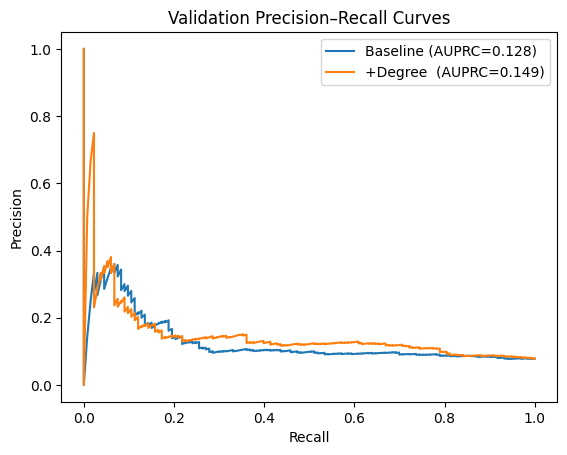

Baseline best thr: 0.6856231689453125 F1: 0.19011406794112967
Degree   best thr: 0.40101122856140137 F1: 0.21287779208999846


In [24]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_loader_base = DataLoader(val_b, batch_size = 4, shuffle = False)
val_loader_deg = DataLoader(val_d, batch_size = 4, shuffle = False)

val_probs_base, val_y_base = collect_probs_and_labels(model_base, val_loader_base, device)
val_probs_deg, val_y_deg = collect_probs_and_labels(model_deg, val_loader_deg, device)

best_base, (prec_b, rec_b, thr_b, f1_b) = pr_metrics(val_probs_base, val_y_base)
best_deg, (prec_d, rec_d, thr_d, f1_d) = pr_metrics(val_probs_deg, val_y_deg)

plt.figure()
plt.plot(rec_b, prec_b, label=f"Baseline (AUPRC={best_base['auprc']:.3f})")
plt.plot(rec_d, prec_d, label=f"+Degree  (AUPRC={best_deg['auprc']:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Validation Precision–Recall Curves")
plt.legend()
plt.show()

print("Baseline best thr:", best_base["best_thr_f1"], "F1:", best_base["best_f1"])
print("Degree   best thr:", best_deg["best_thr_f1"],  "F1:", best_deg["best_f1"])

In [25]:
seeds = [1, 42, 123]
rows = []

for seed in seeds:
    train_b, val_b, test_b = split_dataset(dataset_base, seed=seed)
    train_d, val_d, test_d = split_dataset(dataset_deg,  seed=seed)

    model_base, vb = train_model(train_b, val_b, use_degree=False, seed=seed, epochs=10)
    model_deg,  vd = train_model(train_d, val_d, use_degree=True,  seed=seed, epochs=10)

    tb = eval_on_test(model_base, test_b, vb["best_thr_f1"])
    td = eval_on_test(model_deg,  test_d, vd["best_thr_f1"])

    rows.append({
        "seed": seed,
        "model": "baseline",
        "val_auprc": vb["auprc"],
        "val_best_thr": vb["best_thr_f1"],
        "val_f1": vb["best_f1"],
        "test_auprc": tb["test_auprc"],
        "test_precision": tb["test_precision"],
        "test_recall": tb["test_recall"],
        "test_f1": tb["test_f1"],
    })
    rows.append({
        "seed": seed,
        "model": "degree",
        "val_auprc": vd["auprc"],
        "val_best_thr": vd["best_thr_f1"],
        "val_f1": vd["best_f1"],
        "test_auprc": td["test_auprc"],
        "test_precision": td["test_precision"],
        "test_recall": td["test_recall"],
        "test_f1": td["test_f1"],
    })

report = pd.DataFrame(rows)
display(report)

summary = report.groupby("model")[["test_auprc","test_precision","test_recall","test_f1"]].agg(["mean","std"])
display(summary)

REPORT_PATH = OUT_DIR / "day7_metrics_report.csv"
report.to_csv(REPORT_PATH, index=False)
print("Saved:", REPORT_PATH)


,seed,model,val_auprc,val_best_thr,val_f1,test_auprc,test_precision,test_recall,test_f1
0,1,baseline,0.131324,0.480885,0.217617,0.062201,0.060423,0.363636,0.103627
1,1,degree,0.156984,0.682649,0.232932,0.088784,0.099548,0.200000,0.132931
2,42,baseline,0.147645,0.507382,0.194858,0.129824,0.097964,0.687500,0.171492
3,42,degree,0.148628,0.629143,0.221198,0.157258,0.143258,0.455357,0.217949
4,123,baseline,0.099634,0.609467,0.184028,0.072119,0.058201,0.370787,0.100610
5,123,degree,0.118749,0.601643,0.215686,0.096353,0.064655,0.505618,0.114650


test_auprc           test_precision           test_recall            \
               mean       std           mean       std        mean       std   
model                                                                          
baseline   0.088048  0.036517       0.072196  0.022344    0.473974  0.184953   
degree     0.114132  0.037540       0.102487  0.039384    0.386992  0.163878   

           test_f1            
              mean       std  
model                         
baseline  0.125243  0.040081  
degree    0.155176  0.055126

Saved: /content/drive/MyDrive/biolip_gnn/out/day7_metrics_report.csv
